# Haar Cascadesを使った顔検出
* 目的

このチュートリアルでは
        - Haar特徴に基づくカスケード型分類器を使った顔検出の基礎を学ぶ．
        - 同じ手法を目の検出などに拡張する．

## 基礎
Haar特徴に基づくカスケード(cascade)型分類器を使った物体検出は、Paul Viola & Michael Jonesの2001年の論文”Rapid Object Detection using a Boosted Cascade of Simple Features”で提案された効率の良い物体検出手法である．この手法では、分類を多段に連続して行うカスケード関数を、大量の正例と負例の画像を使い機械学習により作る．そして学習が終わると，入力画像中の物体の検出に用いる．

ここでは顔の検出を扱う．まず、このアルゴリズムは分類器の学習に大量の正例(顔画像)と負例(顔でない画像)を必要とする．そして何らかの特徴量を抽出する。このために下図に示すようなHaar特徴量が使われる．この特徴量は(平滑化で用いられた)畳み込みのためのカーネルのようなものであり、それぞれ(下図に示す)黒い矩形領域の画素の総和から白い矩形領域の画素の総和を引いた値として定義される．


##    Haar Features 

それぞれのカーネルに対し、あらゆるサイズと位置を考え、大量の特徴量を求める。(それにはどのぐらいの計算が必要か、想像してみよう．24x24のサイズの窓領域としても、160,000個以上の特徴量になる)．それぞれの特徴量の計算に、白・黒の矩形領域の画素値の総和の計算を必要とする．この大量の計算を効率よく行うために，Viola &amp; Jonesは __積分画像(integral images)__ を提案した．これは画素値の総和計算を単純化し，どれだけ画素が大量にあっても、たった4画素分の処理で計算をすませるようなアルゴリズムである．すごくないだろうか？これにより処理をとてつもなく高速化できるのである．

![](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/_images/haar_features.jpg)

しかし、計算によって得られる大量の特徴量のうち、その大半は実は重要ではない．その例として下図を考えてみよう。上段の画像は「良い」特徴の例である．1番目の特徴量は目の周りの領域が鼻や頬の領域に比べて暗い、という性質を捉えている。2番目の特徴は、目が眉間より暗いという性質を捉えている．しかしながら，これを目の領域にではなく、頬の上やそれ以外の領域に適用しても無駄である．それでは，どうすれば160,000個以上もある特徴量から最適なものを選べるのだろうか?その答えは アダブースト(Adaboost) である．

![](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/_images/haar.png)

## Face Detection 

まず、すべての特徴量候補をすべての学習画像に適用する。そして顔の画像を正と負に分類する最適な閾値を求める。しかしながら当然、誤分類が起きる。そこで、最小の誤り率をもつ、つまり顔と顔でないものを最もよく分類する特徴量を選ぶ。(この処理は言うほど簡単ではない．最初は入力画像はみな重みが等しいが、分類が進むに連れ、誤識別が起きる画像の重み重みが増やされ、繰り返し学習(この処理)が行われる。これは要求される精度もしくは誤り率に達するか、設定しておいた個数の特徴量が見つかるまで、誤り率の再計算と重みの再計算が繰り返される。)．

最終的に得られる分類器は、「弱い」分類器にそれぞれ重みをつけた集合体である．「弱い」分類器と呼ぶ理由は，それ単体では画像分類ができないからである。しかしこれらを組み合わせることにより「強力な」分類器が作られる．Viola &amp; Jonesの論文では200個の特徴量だけで95%の精度を実現できたと書かれている．最終版では約6,000個の特徴量が使われていた(特徴量が160,000個以上というのに比べれば、かなり数を減らせたと言えるだろう)．

これで顔検出の準備が整った．入力画像に対して24x24のサイズの小領域をとり、6,000個の特徴量を適用し，顔かどうかを判定する．しかし、しかし。。。これだとちょっと効率が悪く、時間を食わないだろうか。そこで、Viola &amp; Jonesは良い解決策を提案している．

画像において、その大半の領域は顔ではない．そこで、小領域が顔ではないことをチェックできる簡単な方法があればよい．もし顔でなければ，その領域を捨てて，二度と処理しないことにする．そして顔の可能性がある領域に処理を集中するのである．このようにして、顔である可能性のある領域を調べるために時間をかけられるようになる．

このために彼らが提案したのは分類器の__カスケード(多段処理)__である．一つの対象領域に対し全部で6,000個ある特徴量を適用することはしない。そうではなく、特徴量を異なる処理段階用のグループに分け，グループごとに順番に特徴量を計算する(普通、最初の方のグループの特徴量はとても少ない)．対象領域が最初のグループの特徴量により顔ではないと分類されれば，それ以上の処理は行われない．最初のグループで合格した場合だけ、次のグループの特徴量が適用される。そして、第三，第四，...と処理を続けていく．すべてのグループの分類を合格したものだけが顔の領域とみなされる。賢いやり方である！

彼らの論文では6,000個以上の特徴量を38個のグループに分け，最初の5グループの特徴量の個数をそれぞれ1, 10, 25, 25, 50としている(上の図で示した二つの特徴量は、実際にアダブーストにより得られた最も良い特徴量である)．著者によると，一つの小領域に対し平均10個の特徴量が計算されるそうである．

以上がViola-Jonesの顔検出のアルゴリズムの概要である．このアルゴリズムについて詳しく知りたければ，補足資料(原論文へのリンクもある)を参照すること．


## OpenCVのHaar-cascadeを用いた顔検出

OpenCVは学習機と検出器の両方を提供している．自分で(例えば車や植物を検出するための)分類器を作りたければ，OpenCVを用いて機械学習により作ることができる．詳しくは以下の資料を参照のこと: [カスケード分類器の学習(英語版)](http://docs.opencv.org/doc/user_guide/ug_traincascade.html)

ここでは検出を扱う．OpenCVは顔、目、鼻、笑顔など、学習済みの分類器を多数提供している。これらはXMLファイルとして [opencv/data/haarcascades/](https://github.com/opencv/opencv/tree/master/data/haarcascades)ディレクトリにある．ここではOpenCVを用いて顔と目の検出器を作成しよう。

まず初めに必要となるXMLファイルを読み込み，次に入力画像(動画像でもよい)をグレースケールで読み込む．

<font color="red">注意</font>: 上記のディレクトリのファイルはそのままではダウンロードできない。ファイル名をクリックしてから、Rawを選ぶこと。例えば、haarcascades_frontalface_default.xmlファイルは、[ここ](https://github.com/opencv/opencv/raw/master/data/haarcascades/haarcascade_frontalface_default.xml) から、またhaarcascades_eye.xmlファイルは[ここ](https://github.com/opencv/opencv/raw/master/data/haarcascades/haarcascade_eye.xml)からダウンロードする。なお、haarcscadesファイルはOpenCVが走っているマシンであれば必ず用意されているはずなので、ダウンロードせずにそのファイルを使ったほうが確かである。

In [20]:
import numpy as np
import cv2

face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')

次に入力画像に対し顔検出を行う．顔が検出された時は、顔の位置が`Rect(x,y,w,h)`として返される．この位置情報から、顔に対する注目領域(ROI)を作り，このROIにおいて目の検出を行うことができる(なぜなら目は常に顔の中に位置するからである!!)．

ここでは以下の写真を用いる。これを [faces.jpg](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/Notebook/faces.jpg) として参照することとする
![](http://lang.sist.chukyo-u.ac.jp/Classes/OpenCV/Notebook/faces.jpg)

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt

img = cv2.imread('faces.jpg')
# plt.imshow(cv2.cvtColor(img,cv2.COLOR_RGB2BGR))

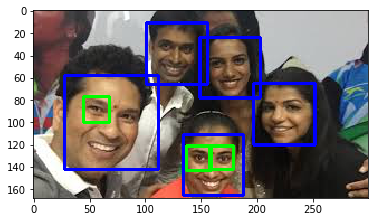

In [22]:
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(gray, 1.3, 5)
for (x,y,w,h) in faces:
    img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)

plt.imshow(cv2.cvtColor(img,cv2.COLOR_RGB2BGR))

## 補助資料
1.  Video Lecture on [Face Detection and Tracking](http://www.youtube.com/watch?v=WfdYYNamHZ8)
2.  顔検出に関する興味深いインタビュー [Adam Harvey](https://vimeo.com/39561082)
3. Paul Viola &amp; Michael Jones. (2001). ["Rapid Object Detection using a Boosted Cascade of Simple Features"](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.10.6807).Computer Vision and Pattern Recognition (CVPR). pp. 511-518.



## 参考
* [dlib](http://dlib.net/ml.html)を用いた顔検出: Anacondaであれば、`pip install imutils dlib` (注意: cmakeを予めインストールしておくこと)により dlib が使えるようになる---顔の輪郭や口、目、鼻などの特徴点まで抽出可能<BR>
    以下を使うには[shape_predictor_68_face_landmarks.dat](http://lang.sist.chukyo-u.ac.jp/Classes/seminar/2017/shape_predictor_68_face_landmarks.dat)ファイルが必要である<BR>
   出典: Adrian Rosebrock (2017) [Facial landmarks with dlib, OpenCV, and Python](https://www.pyimagesearch.com/2017/04/03/facial-landmarks-dlib-opencv-python/)

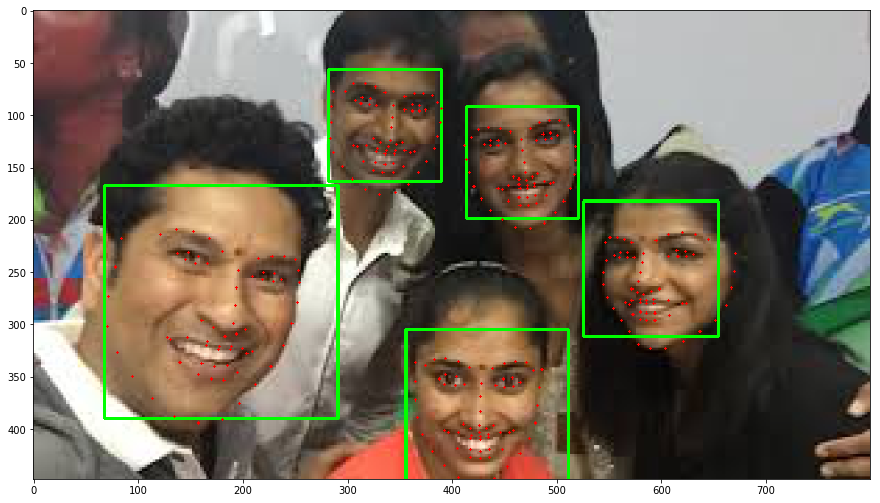

In [25]:
%matplotlib inline
# import the necessary packages
import matplotlib.pyplot as plt
from imutils import face_utils
import numpy as np
import argparse
import imutils
import dlib
import cv2

# 以下はコマンドラインからの起動のための引数解析用
"""
# construct the argument parser and parse the arguments
ap = argparse.ArgumentParser()
ap.add_argument("-p", "--shape-predictor", required=True,
        help="path to facial landmark predictor")
ap.add_argument("-i", "--image", required=True,
        help="path to input image")
args = vars(ap.parse_args())
"""

# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor
detector = dlib.get_frontal_face_detector()
# predictor = dlib.shape_predictor(args["shape_predictor"])
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

# load the input image, resize it, and convert it to grayscale
# image = cv2.imread(args["image"])
image = cv2.imread("faces.jpg")
image = imutils.resize(image, width=800)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# detect faces in the grayscale image
rects = detector(gray, 1)

# loop over the face detections
for (i, rect) in enumerate(rects):
        # determine the facial landmarks for the face region, then
        # convert the facial landmark (x, y)-coordinates to a NumPy
        # array
        shape = predictor(gray, rect)
        shape = face_utils.shape_to_np(shape)

        # convert dlib's rectangle to a OpenCV-style bounding box
        # [i.e., (x, y, w, h)], then draw the face bounding box
        (x, y, w, h) = face_utils.rect_to_bb(rect)
        # make a bounding box around the face
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        # loop over the (x, y)-coordinates for the facial landmarks
        # and draw them on the image
        for (x, y) in shape:
              cv2.circle(image, (x, y), 1, (0, 0, 255), -1)
        
# show the output image with the face detections + facial landmarks
plt.figure(figsize=(15,10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()
